# Homework 2: Augmented Reality with Planar Homographies

#### **For each question please refer to the handout for more details.**

Programming questions begin at **Q2**. **Remember to run all cells** and save the notebook to your local machine as a pdf for gradescope submission.

# Collaborators
**List your collaborators for all questions here**:


---

# Q1 Preliminaries

## Q1.1 The Direct Linear Transform


### Q1.1.1 (3 points)

How many degrees of freedom does **h** have?

---

8

---

### Q1.1.2 (2 points)

How many point pairs are required to solve **h**?

---

4 pairs

---

### Q1.1.3 (5 points)

Derive $\textbf{A}_i$

---

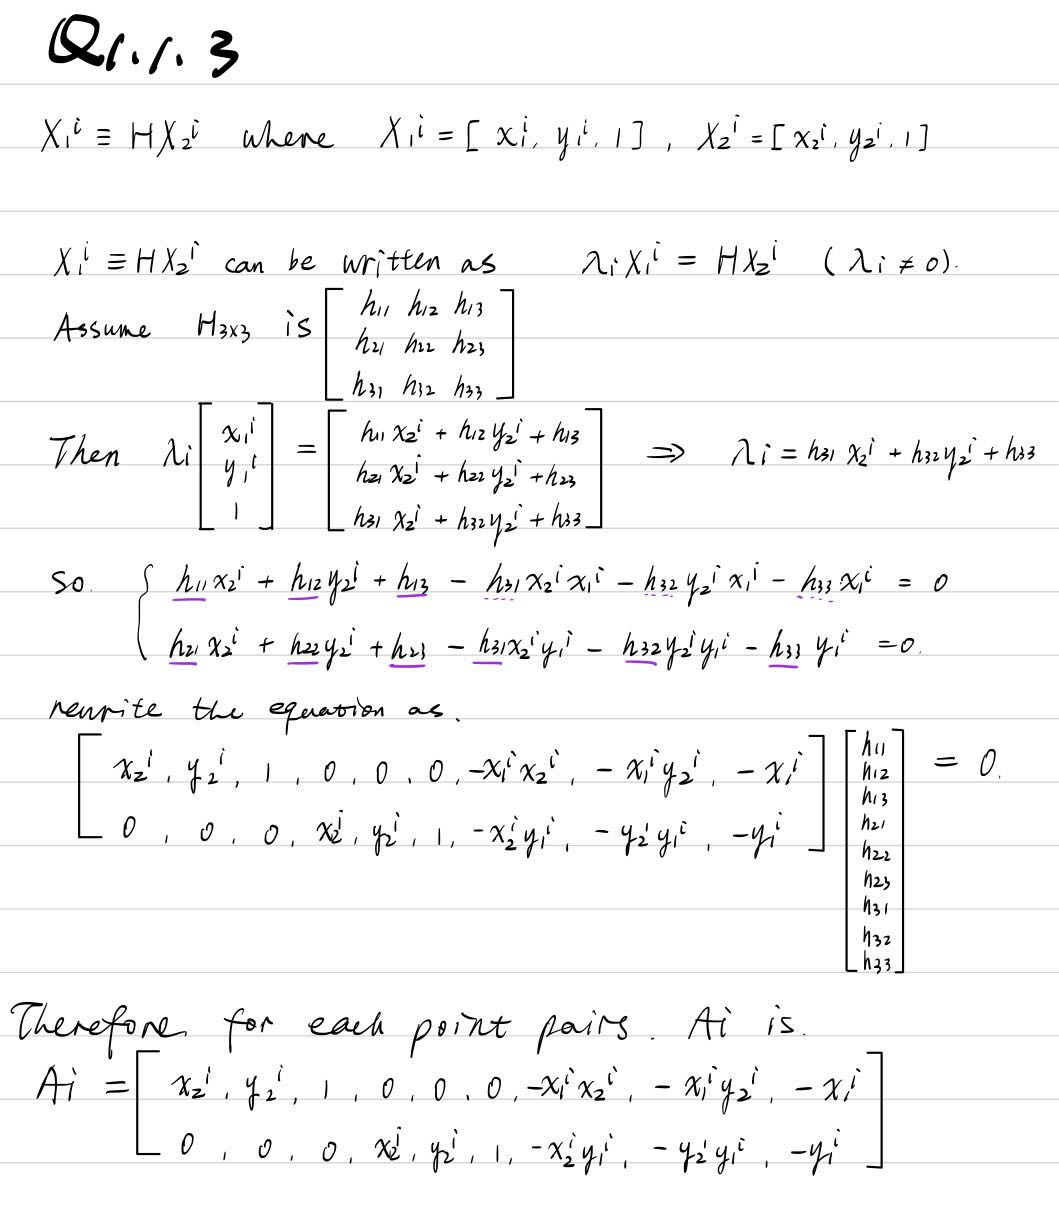

---

### Q1.1.4 (5 points)

What will be the trivial solution for **h**? Is the matrix **A** full rank? Why/Why not? What impact will it have on the singular values (i.e. eigenvalues of $\textbf{A}^T\textbf{A}$)?

---

1. Vector *h* = 0 is the trivial solution
2. Matrix *A* is not full rank.
3. Assuming there are 4 point pairs in general position, each providing 2 independent equations, the matrix *A* will have a rank of 8. Matrix *A* has 9 columns, so it is not full rank.
4. Due to *A* is rank-deficient by one, the smallest singular value of A will be zero. The singular values of *A*T*A* will reflect this by having one very small eigenvalue corresponding to the null space where the non-trivial solution *h* resides.
---

## Q1.2 Homography Theory Questions

### Q1.2.1 (5 points)

Prove that there exists a homography **H** that satisfies $\textbf{x}_1 ≡ \textbf{Hx}_2$, given two cameras separated by a pure rotation.

---

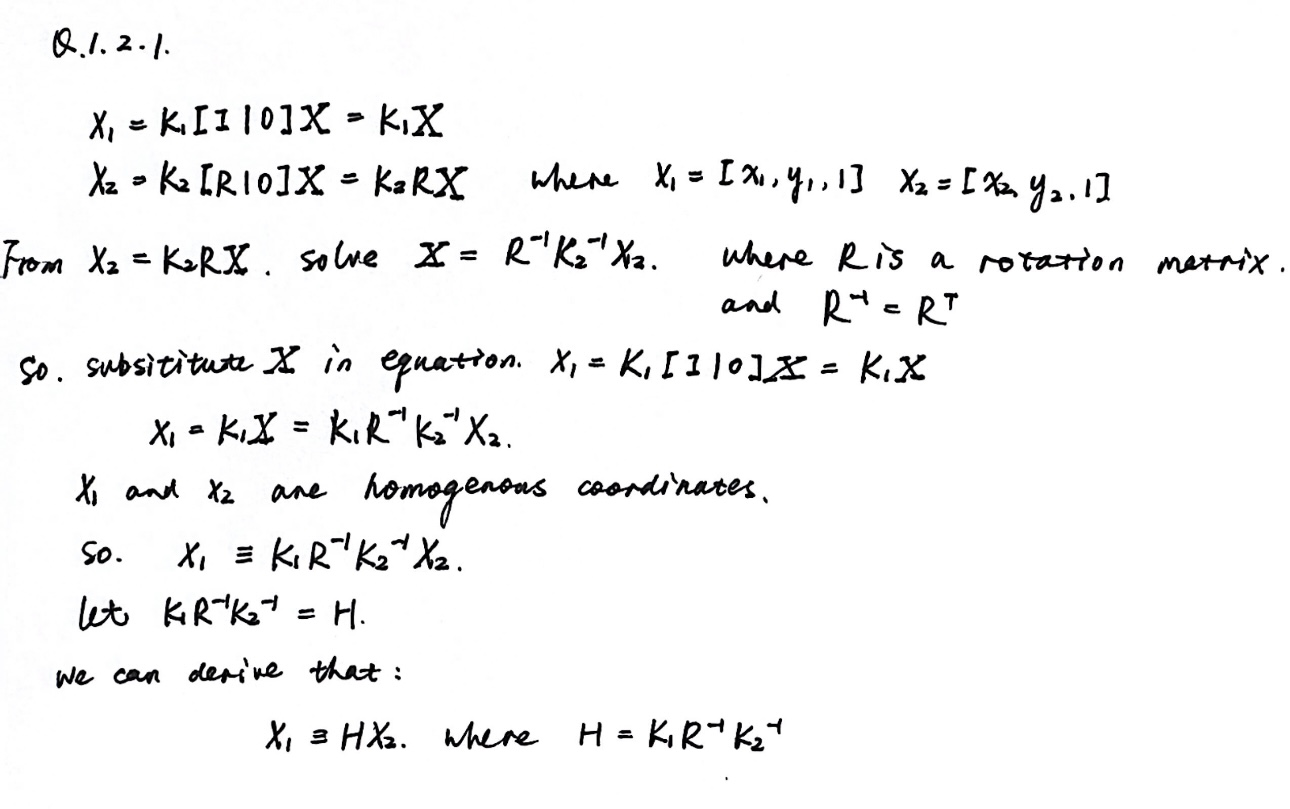


---

### Q1.2.2 (5 points):

Show that $\textbf{H}^2$ is the homography corresponding to a rotation of 2$\theta$.

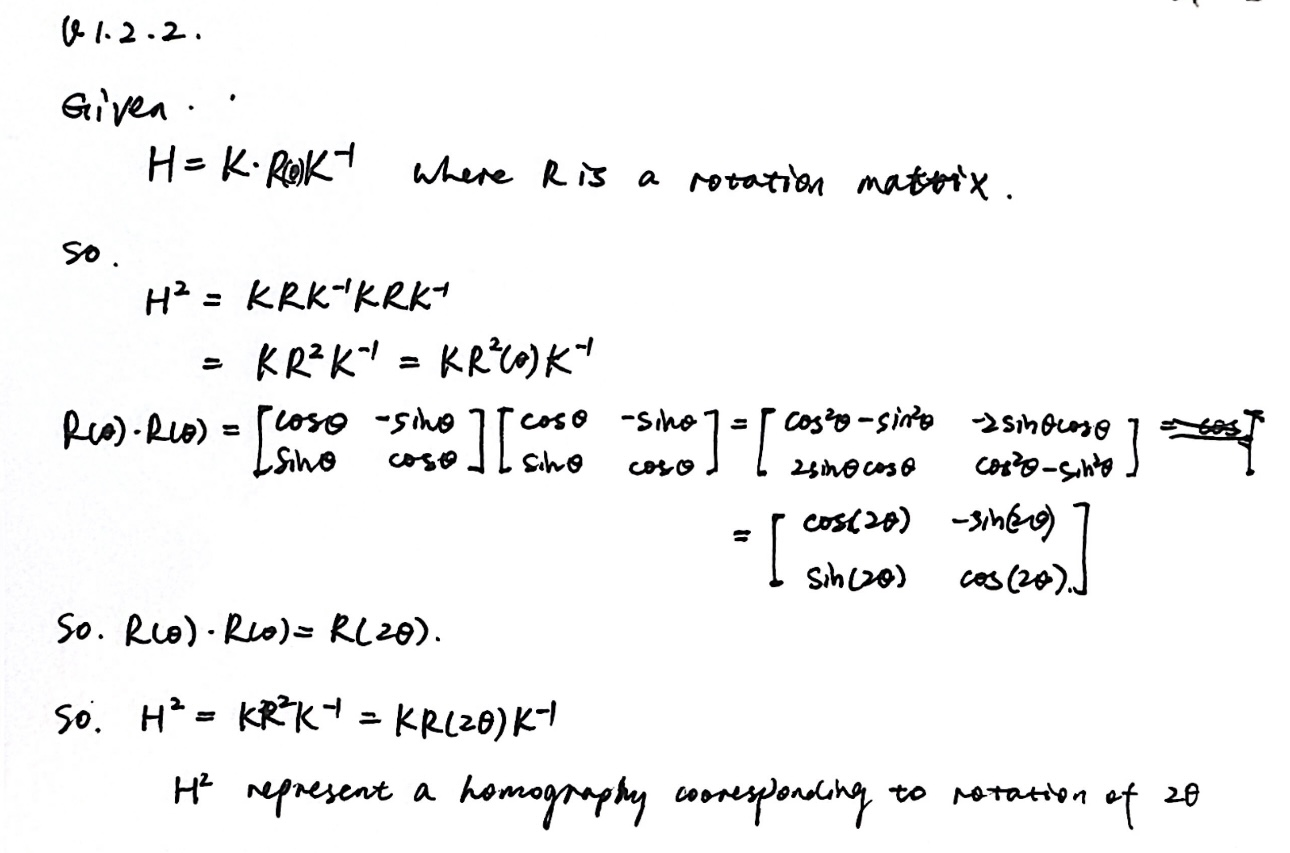

# Initialization

Run the following code to import the modules you'll need.

In [43]:
import os
import numpy as np
import cv2
import skimage.color
import pickle
from matplotlib import pyplot as plt
import scipy
from skimage.util import montage
import time

PATCHWIDTH = 9

def read_pickle(path):
    with open(path, "rb") as f:
        return pickle.load(f)

def write_pickle(path, data):
    with open(path, "wb") as f:
        pickle.dump(data, f)

def briefMatch(desc1,desc2,ratio):

    matches = skimage.feature.match_descriptors(desc1,desc2,
                                                'hamming',
                                                cross_check=True,
                                                max_ratio=ratio)
    return matches

def plotMatches(img1,img2,matches,locs1,locs2):

    fig, ax = plt.subplots(nrows=1, ncols=1)
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    plt.axis('off')
    skimage.feature.plot_matches(ax,img1,img2,locs1,locs2,
                                 matches,matches_color='r',only_matches=True)
    plt.show()
    return

def makeTestPattern(patchWidth, nbits):

    np.random.seed(0)
    compareX = patchWidth*patchWidth * np.random.random((nbits,1))
    compareX = np.floor(compareX).astype(int)
    np.random.seed(1)
    compareY = patchWidth*patchWidth * np.random.random((nbits,1))
    compareY = np.floor(compareY).astype(int)

    return (compareX, compareY)

def computePixel(img, idx1, idx2, width, center):

    halfWidth = width // 2
    col1 = idx1 % width - halfWidth
    row1 = idx1 // width - halfWidth
    col2 = idx2 % width - halfWidth
    row2 = idx2 // width - halfWidth
    return 1 if img[int(center[0]+row1)][int(center[1]+col1)] < img[int(center[0]+row2)][int(center[1]+col2)] else 0

def computeBrief(img, locs):

    patchWidth = 9
    nbits = 256
    compareX, compareY = makeTestPattern(patchWidth,nbits)
    m, n = img.shape

    halfWidth = patchWidth//2

    locs = np.array(list(filter(lambda x: halfWidth <= x[0] < m-halfWidth and halfWidth <= x[1] < n-halfWidth, locs)))
    desc = np.array([list(map(lambda x: computePixel(img, x[0], x[1], patchWidth, c), zip(compareX, compareY))) for c in locs])

    return desc, locs

def corner_detection(img, sigma):

    # fast method
    result_img = skimage.feature.corner_fast(img, n=PATCHWIDTH, threshold=sigma)
    locs = skimage.feature.corner_peaks(result_img, min_distance=1)
    return locs

def loadVid(path):

    # Create a VideoCapture object and read from input file
    # If the input is the camera, pass 0 instead of the video file name

    cap = cv2.VideoCapture(path)

    # get fps, width, and height
    fps = cap.get(cv2.CAP_PROP_FPS)
    width  = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
    height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)

    # Append frames to list
    frames = []

    # Check if camera opened successfully
    if cap.isOpened()== False:
        print("Error opening video stream or file")

    # Read until video is completed
    while(cap.isOpened()):

        # Capture frame-by-frame
        ret, frame = cap.read()

        if ret:
            #Store the resulting frame
            frames.append(frame)
        else:
            break

    # When everything done, release the video capture object
    cap.release()
    frames = np.stack(frames)

    return frames, fps, width, height

# Download data

Download the required data and setup the results directory. If running on colab, DATA_PARENT_DIR must be <br> DATA_PARENT_DIR = '/content/' <br> <br> Otherwise, use the local directory of your choosing. Data will be downloaded to DATA_PARENT_DIR/hw3_data and a subdirectory DATA_PARENT_DIR/results will be created.

In [44]:
# Only change this if you are running locally
# Default on colab: DATA_PARENT_DIR = '/content/'

# Data will be downloaded to DATA_PARENT_DIR/hw3_data
# A subdirectory DATA_PARENT_DIR/results will be created

DATA_PARENT_DIR = '/content/'

if not os.path.exists(DATA_PARENT_DIR):
  raise RuntimeError('DATA_PARENT_DIR does not exist: ', DATA_PARENT_DIR)

RES_DIR = os.path.join(DATA_PARENT_DIR, 'results')
if not os.path.exists(RES_DIR):
  os.mkdir(RES_DIR)
  print('made directory: ', RES_DIR)


#paths different files are saved to
# OPTIONAL:
# feel free to change if funning locally
ROT_MATCHES_PATH = os.path.join(RES_DIR, 'brief_rot_test.pkl')
ROT_INV_MATCHES_PATH = os.path.join(RES_DIR, 'ec_brief_rot_inv_test.pkl')
AR_VID_FRAMES_PATH = os.path.join(RES_DIR, 'q_3_1_frames.npy')
AR_VID_FRAMES_EC_PATH = os.path.join(RES_DIR, 'q_3_2_frames.npy')

HW3_SUBDIR = 'hw3_data'
DATA_DIR = os.path.join(DATA_PARENT_DIR, HW3_SUBDIR)
ZIP_PATH = DATA_DIR + '.zip'
if not os.path.exists(DATA_DIR):
  !wget 'https://www.andrew.cmu.edu/user/hfreeman/data/16720_spring/hw3_data.zip' -O $ZIP_PATH
  !unzip -qq $ZIP_PATH -d $DATA_PARENT_DIR

# Q2 Computing Planar Homographies

## Q2.1 Feature Detection and Matching

### Q2.1.1 (5 points):

How is the FAST detector different from the Harris corner detector that you've seen in the lectures? Can you comment on its computation performance compared to the Harris corner detector?

---

`Harris Corner Detector`

Harris Corner Detector is based on analyzing the intensity gradients of an image. For each pixel, it computes the gradient covariance matrix within a window surrounding the pixel and evaluates the eigenvalues of this matrix to determine if the region is a corner.

`FAST Detector`

The FAST Detector compares the intensity of a candidate pixel with its surrounding pixels within a circle which contains 16 pixels. A pixel will be classified as a corner if there exists a set of *n* contiguous pixels in the circle that are all brighter or all darker than the candidate pixel by a specific threshold.

`Comment On Performance`

1. FAST has much lower amount of computing compared to Harris Corner detecor because  it doesn't require calculation gradients or operating matrix, it just a comparison of brightness.
2. Due to the low amount of computing, FAST can reach a faster speed than Harris, making it ideal for real-time applications.
3. FAST is more sensitive to noise than Harris because noise tends to have a sharp change in brightness. So FAST is less robust.
4. Threshold and the size of the circle need to be tuned according the application.


---

### Q2.1.2 (5 points):

How is the BRIEF descriptor different from the filterbanks you've seen in the lectures? Could you use any one of the those filter banks as a descriptor?

---

`Difference`

1. BRIEF Descriptor is based on the comparison of pixels' grayscale while Filter Banks is based on the convolution of the image.
2. The result of applying BRIEF Descriptor is a binary string while the results of applying Filter Banks are vectors with high dimensions.
3. BRIEF uses hamming distance to which has lower computational cost than Euclidean used by Filter Banks.
4. BRIEF is suitable for real-time tasks while Filter Bank is suitable for extracting features in non real-time tasks.
5.  focuses on capturing the unique patterns around keypoints to facilitate efficient matching.

`Whether we can use filter banks as a descriptor`

Filter responses provide rich information about the image but are usually high-dimensional and may not be as efficient for tasks like feature matching. However, I think the outputs of filterbanks may be used as part of a feature descriptor, like combined with dimensional reduction and use it as a local feature instead of a gloabal feature.


---

### Q2.1.3 (5 points):

Describe how the Hamming distance and Nearest Neighbor can be used to match interest points with BRIEF descriptors. What benefits does the Hamming distance have over a more conventional Euclidean distance measure in our setting?

---


`Hamming Distance`

  Hamming distance is a method for comparing two binary strings of equal length, and it calculates the number of different bits between the two strings. In BRIEF descriptors, feature points are represented as binary strings, and Hamming distance can be used to match these descriptors by calculating how different two binary strings are.

`Nearest Neiborhood`

  Nearest Neiborhood find the closest descriptor in another image for each feature point descriptor, serving as a match candidate. For BRIEF descriptors, since they are binary strings, Nearest Neighbor search typically uses the Hamming distance because it effectively measures the difference between two binary descriptors.

`Benefits`

1. High computational efficiency:  

 The Hamming distance calculation involves only XOR operations and counting the number of 1s in the result, which is computationally very efficient. In contrast, Euclidean distance involves floating-point operations, which are relatively complex.

2. Efficient storage and comparison:

 Since BRIEF descriptors are binary, they can be stored more compactly in memory, and comparison can be accelerated through hardware, making the Hamming distance computation faster.


---

### Q2.1.4 (10 points):

#### Implement the function matchPics()

In [45]:
import skimage.io
import skimage.transform
import skimage.feature

def matchPics(I1, I2, ratio, sigma):
    """
    Match features across images

    Input
    -----
    I1, I2: Source images (RGB or Grayscale uint8)
    ratio: ratio for BRIEF feature descriptor
    sigma: threshold for corner detection using FAST feature detector

    Returns
    -------
    matches: List of indices of matched features across I1, I2 [p x 2]
    locs1, locs2: Pixel coordinates of matches [N x 2]
    """
    # Convert images to GrayScale
    if len(I1.shape) == 3 and I1.shape[2] == 3:
        I1 = skimage.color.rgb2gray(I1)
    elif len(I1.shape) == 2 and I1.max() > 1.0:
      ### If grayscale but values are in [0, 255]
        I1 = I1 / 255.0

    if len(I2.shape) == 3 and I2.shape[2] == 3:
        I2 = skimage.color.rgb2gray(I2)
    elif len(I2.shape) == 2 and I2.max() > 1.0:
      ### If grayscale but values are in [0, 255]
        I2 = I2 / 255.0

    # Feature Detection
    locs1 = corner_detection(I1, sigma)
    locs2 = corner_detection(I2, sigma)

    # update locs and obtain descriptors
    desc1, locs1 = computeBrief(I1, locs1)
    desc2, locs2 = computeBrief(I2, locs2)

    # Match features using the descriptors
    matches = briefMatch(desc1, desc2, ratio)
    ### matches save the indies of the matched keypoint

    return matches, locs1, locs2

#### Implement the function displayMatched

In [47]:
def displayMatched(I1, I2, ratio, sigma):
    """
    Displays matches between two images

    Input
    -----
    I1, I2: Source images
    ratio: ratio for BRIEF feature descriptor
    sigma: threshold for corner detection using FAST feature detector
    """
    matches, locs1, locs2 = matchPics(I1, I2, ratio, sigma)

    print('Displaying matches for ratio: ', ratio, ' and sigma: ', sigma)

    print('number of matched points: ', matches.shape[0])

    plotMatches(I1, I2, matches, locs1, locs2)

#### Visualize the matches

Use the cell below to visualize the matches. The resulting figure should look similar (but not necessarily identical) to Figure 2.

Feel free to play around with the images and parameters. Please use the original images when submitting the report.

Figure 2 parameters:

*   image1_name = "cv_cover.jpg"
*   image1_name = "cv_desk.png"
*   ratio = 0.7
*   sigma = 0.15

<ipython-input-43-93856fa3ecc0>:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 if img[int(center[0]+row1)][int(center[1]+col1)] < img[int(center[0]+row2)][int(center[1]+col2)] else 0


Displaying matches for ratio:  0.7  and sigma:  0.15
number of matched points:  24


<ipython-input-43-93856fa3ecc0>:35: FutureWarning: `plot_matches` is deprecated since version 0.23 and will be removed in version 0.25. Use `skimage.feature.plot_matched_features` instead.
  skimage.feature.plot_matches(ax,img1,img2,locs1,locs2,


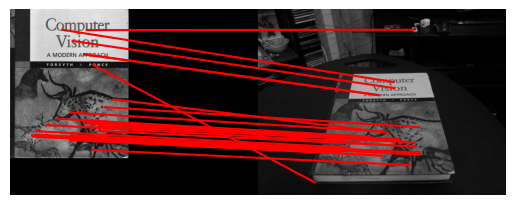

In [48]:
# Feel free to play around with these parameters
# BUT when submitting the report use the original images
image1_name = "cv_cover.jpg"
image2_name = "cv_desk.png"
ratio = 0.7
sigma = 0.15

image1_path = os.path.join(DATA_DIR, image1_name)
image2_path = os.path.join(DATA_DIR, image2_name)

image1 = cv2.imread(image1_path)
image2 = cv2.imread(image2_path)

# bgr to rgb
if len(image1.shape) == 3 and image1.shape[2] == 3:
  image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

if len(image2.shape) == 3 and image2.shape[2] == 3:
  image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

displayMatched(image1, image2, ratio, sigma)

### Q2.1.5 (10 points):

Experiment with different sigma and ratio values. Conduct a small ablation study, and include the figures displaying the matched features with various parameters in your write-up. Explain the effect of these two paremeters respectively.

---

Explain the effect of these two parameters:

The study experimented with the following pairs of (ratio,sigma): [(0.7, 0.15), (0.7, 0.1), (0.7, 0.2), (0.75, 0.15), (0.65, 0.15)]

`sigma`

Low sigma: Detects more corners, including weaker ones, which can lead to a higher number of keypoints but may introduce noise and false positives.

High sigma: Detects fewer, stronger corners, resulting in more reliable keypoints but may miss some details.

`Ratio`

Low Ratio: Select matching points more strict, leading to fewer but more accurate matches.

High Ratio: More relaxed matches, resulting in a higher number of matches but with an increased risk of incorrect pairings.

---

ablation test 
    Changes  ratio  sigma
0  Default   0.70   0.15
1    Sigma   0.70   0.10
2    sigma   0.70   0.20
3    ratio   0.75   0.15
4    ratio   0.65   0.15


<ipython-input-43-93856fa3ecc0>:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 if img[int(center[0]+row1)][int(center[1]+col1)] < img[int(center[0]+row2)][int(center[1]+col2)] else 0


Displaying matches for ratio:  0.7  and sigma:  0.15
number of matched points:  24


<ipython-input-43-93856fa3ecc0>:35: FutureWarning: `plot_matches` is deprecated since version 0.23 and will be removed in version 0.25. Use `skimage.feature.plot_matched_features` instead.
  skimage.feature.plot_matches(ax,img1,img2,locs1,locs2,


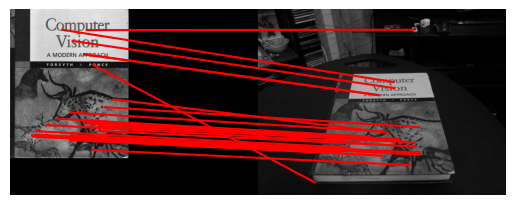



Displaying matches for ratio:  0.7  and sigma:  0.1
number of matched points:  64


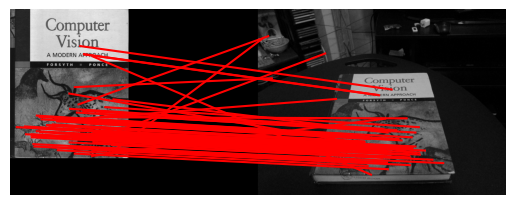



Displaying matches for ratio:  0.7  and sigma:  0.2
number of matched points:  12


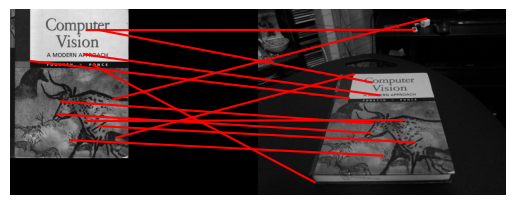



Displaying matches for ratio:  0.75  and sigma:  0.15
number of matched points:  43


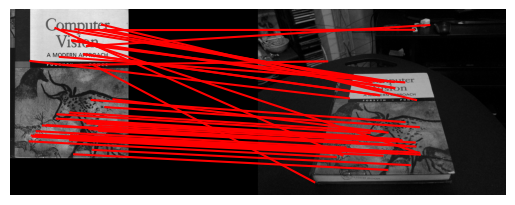



Displaying matches for ratio:  0.65  and sigma:  0.15
number of matched points:  12


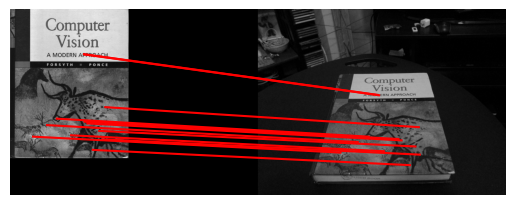

In [49]:
import pandas as pd

image1_name = "cv_cover.jpg"
image2_name = "cv_desk.png"

image1_path = os.path.join(DATA_DIR, image1_name)
image2_path = os.path.join(DATA_DIR, image2_name)

image1 = cv2.imread(image1_path)
image2 = cv2.imread(image2_path)

#bgr to rgb
if len(image1.shape) == 3 and image1.shape[2] == 3:
  image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

if len(image2.shape) == 3 and image2.shape[2] == 3:
  image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

# ===== your code here! =====
# Experiment with different sigma and ratio values.
# Use displayMatches to visualize.
# Include the matched feature figures in the write-up.


# ablation test
data = {
    'Changes': ['Default', 'Sigma', 'sigma', 'ratio', 'ratio'],
    'ratio': [0.7, 0.7, 0.7, 0.75, 0.65],
    'sigma': [0.15, 0.1, 0.2, 0.15, 0.15]
       }

df = pd.DataFrame(data)

print("ablation test", '\n',df)

parameters = [(0.7, 0.15), (0.7, 0.1), (0.7, 0.2), (0.75, 0.15), (0.65, 0.15)]
for ratio, sigma in parameters:
    displayMatched(image1, image2, ratio, sigma)
    print('\n')


# ==== end of code ====

### Q2.1.6 (10 points):

#### Implement the function briefRot

In [51]:
import scipy.ndimage

def briefRot(min_deg, max_deg, deg_inc, ratio, sigma, filename):
    """
    Tests Brief with rotations.

    Input
    -----
    min_deg: minimum degree to rotate image
    max_deg: maximum degree to rotate image
    deg_inc: number of degrees to increment when iterating
    ratio: ratio for BRIEF feature descriptor
    sigma: threshold for corner detection using FAST feature detector
    filename: filename of image to rotate

    """
    if not os.path.exists(RES_DIR):
       raise RuntimeError('RES_DIR does not exist. did you run all cells?')

    # Read the image and convert bgr to rgb
    image_path = os.path.join(DATA_DIR, filename)
    image = cv2.imread(image_path)
    if len(image.shape) == 3 and image.shape[2] == 3:
       image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    match_degrees = [] # degrees of rotation
    match_counts = [] # number of matches at each degree of rotation
    j = 0 # control the number of pictures shown
    for i in range(min_deg, max_deg, deg_inc):
        print(i)

        # Rotate Image
        image_rotate = scipy.ndimage.rotate(image, i)
        ### the function will fill up the vacancy with black pixels
        ### and remain the origin coordinates

        # Match features in images
        matches, locs1, locs2 = matchPics(image, image_rotate, ratio, sigma)

        match_count = len(matches)
        # visualizes matches at at least 3 different orientations
        displayMatched(image, image_rotate, ratio,
                       sigma) if j in (0,1,2) else None # show 3 pics
        j += 1

        #Update match_degrees and match_counts
        match_degrees.append(i)
        match_counts.append(match_count)

    print('match counts','\n',match_counts,'\n','match_degree',
          '\n', match_degrees)

    # Save to pickle file
    matches_to_save = [match_counts, match_degrees, deg_inc]
    write_pickle(ROT_MATCHES_PATH, matches_to_save)

def dispBriefRotHist(matches_path=ROT_MATCHES_PATH):
    # Check if pickle file exists
    if not os.path.exists(matches_path):
      raise RuntimeError('matches_path does not exist. did you call briefRot?')

    # Read from pickle file
    match_counts, match_degrees, deg_inc = read_pickle(matches_path)

    # Display histogram
    # Bins are centered and separated every 10 degrees
    plt.figure()
    bins = [x - deg_inc/2 for x in match_degrees]
    bins.append(bins[-1] + deg_inc)
    plt.hist(match_degrees, bins=bins, weights=match_counts, log=True)
    # plt.hist(match_degrees, bins=[10 * (x-0.5) for x in range(37)],
    # weights=match_counts, log=True)
    plt.title("Histogram of BREIF matches")
    plt.ylabel("# of matches")
    plt.xlabel("Rotation (deg)")
    plt.tight_layout()

    output_path = os.path.join(RES_DIR, 'histogram.png')
    plt.savefig(output_path)

#### Visualize the matches under rotation

See debugging tips in handout.


0


<ipython-input-43-93856fa3ecc0>:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 if img[int(center[0]+row1)][int(center[1]+col1)] < img[int(center[0]+row2)][int(center[1]+col2)] else 0


Displaying matches for ratio:  0.7  and sigma:  0.15
number of matched points:  945


<ipython-input-43-93856fa3ecc0>:35: FutureWarning: `plot_matches` is deprecated since version 0.23 and will be removed in version 0.25. Use `skimage.feature.plot_matched_features` instead.
  skimage.feature.plot_matches(ax,img1,img2,locs1,locs2,


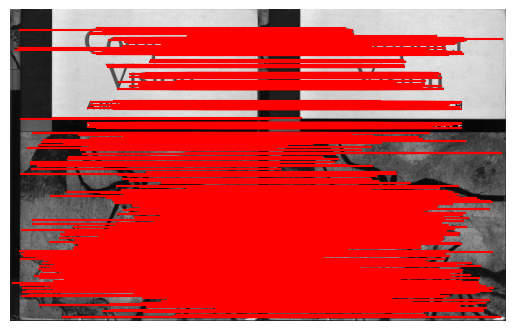

10
Displaying matches for ratio:  0.7  and sigma:  0.15
number of matched points:  94


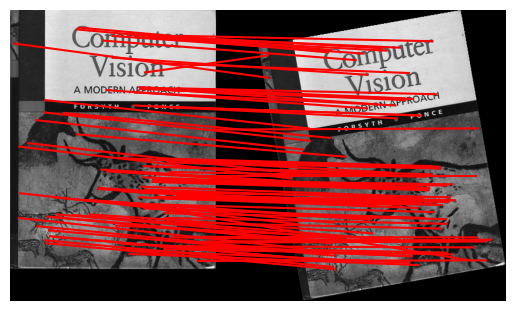

20
Displaying matches for ratio:  0.7  and sigma:  0.15
number of matched points:  5


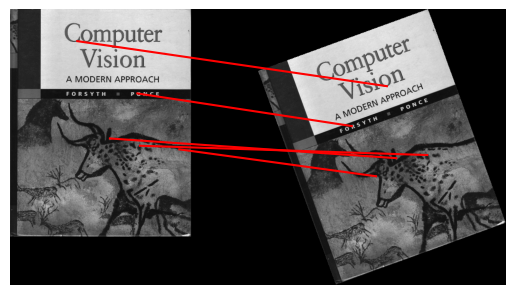

30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
match counts 
 [945, 94, 5, 3, 3, 3, 4, 2, 6, 3, 7, 0, 2, 5, 6, 3, 5, 2, 7, 4, 3, 4, 0, 5, 6, 3, 6, 3, 4, 8, 5, 5, 6, 6, 7, 98] 
 match_degree 
 [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350]


In [52]:
# defaults are:
# min_deg = 0
# max_deg = 360
# deg_inc = 10
# ratio = 0.7
# sigma = 0.15
# filename = 'cv_cover.jpg'

# Controls the rotation degrees
min_deg = 0
max_deg = 360                  ##### can be modified
deg_inc = 10
ratio = 0.7
sigma = 0.15
filename = 'cv_cover.jpg'

# Call briefRot
briefRot(min_deg, max_deg, deg_inc, ratio, sigma, filename)

#### Plot the histogram

See debugging tips in handout.

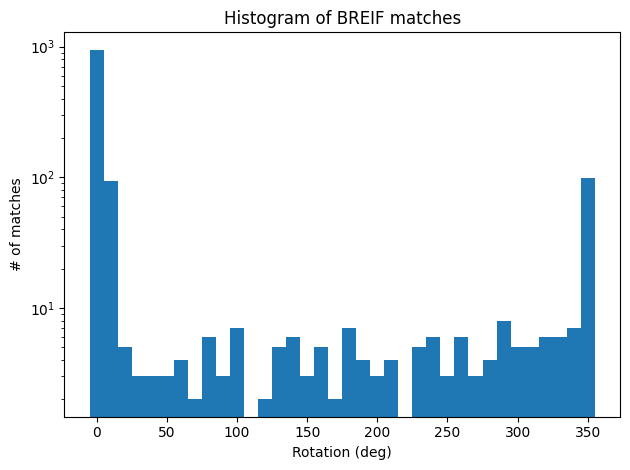

In [53]:
dispBriefRotHist()

---

`Why BRIEF descriptor behaves this way`

BRIEF works by comparing the intensity of certain pixel pairs in a local area to generate a binary descriptor. When an image is rotated, the relative positions of these pixel pairs change which leads to changes in the descriptor and reduced matching accuracy. This is why the number of matches decreases significantly as the rotation angle increases.


---

### Q2.1.7.1 (Extra Credit - 5 points):

Design a fix to make BRIEF more rotation invariant. Feel free to make any helper functions as necessary. But you cannot use any additional OpenCV or Scikit-Image functions.

In [ ]:
# ===== your code here! =====
# TODO: Define any helper functions here
# (Feel free to put anything in its own cell)

# TODO: Feel free to modify the inputs and the function body as necessary
# This is only an outline
def briefRotInvEc(min_deg, max_deg, deg_inc, ratio, sigma, filename):
    """
    Rotation invariant Brief.

    Input
    -----
    min_deg: minimum degree to rotate image
    max_deg: maximum degree to rotate image
    deg_inc: number of degrees to increment when iterating
    ratio: ratio for BRIEF feature descriptor
    sigma: threshold for corner detection using FAST feature detector
    filename: filename of image to rotate

    """

    if not os.path.exists(RES_DIR):
      raise RuntimeError('RES_DIR does not exist. did you run all cells?')

    #Read the image and convert bgr to rgb
    image_path = os.path.join(DATA_DIR, filename)
    image = cv2.imread(image_path)
    if len(image.shape) == 3 and image.shape[2] == 3:
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    match_degrees = [] # stores the degrees of rotation
    match_counts = [] # stores the number of matches at each degree of rotation

    for i in range(min_deg, max_deg, deg_inc):
        print(i)

        # TODO: Rotate Image (Hint: use scipy.ndimage.rotate)

        # TODO: Brief matcher that is rotation invariant
        # Feel free to define additional helper functions as necessary

        # TODO: visualizes matches at at least 3 different orientations
        # to include in your report
        # (Hint: use plotMatches)

        # TODO: Update match_degrees and match_counts (see descriptions above)

    # Save to pickle file
    matches_to_save = [match_counts, match_degrees, deg_inc]
    write_pickle(ROT_INV_MATCHES_PATH, matches_to_save)

# ==== end of code ====

#### Visualize your implemented function


In [ ]:
min_deg = 0
max_deg = 360
deg_inc = 10
filename = 'cv_cover.jpg'

# ===== your code here! =====
# TODO: Call briefRotInvEc and visualize

# ==== end of code ====


#### Plot Histogram

In [ ]:
dispBriefRotHist(matches_path=ROT_INV_MATCHES_PATH)

---

Compare the histograms with an without rotation invariance. Explain your rotation invariant design and how you selected any parameters that you used: YOUR ANSWER HERE...

---

### Q2.1.7.2 (Extra Credit - 5 points):

Design a fix to make BRIEF more scale invariant. Feel free to make any helper functions as necessary. But you cannot use any additional OpenCV or Scikit-Image functions.


In [ ]:
# ===== your code here! =====
# TODO: Define any helper functions here
# (Feel free to put anything in its own cell)

# TODO: Modify the inputs and the function body as necessary
def briefScaleInvEc(ratio, sigma, filename):

    #Read the image and convert bgr to rgb
    image_path = os.path.join(DATA_DIR, filename)
    image = cv2.imread(image_path)
    if len(image.shape) == 3 and image.shape[2] == 3:
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    match_scales = [] # stores the scaling factors
    match_counts = [] # stores the number of matches at each scaling factor

    for i in [1]:
        # Scale Image
        image_scale = cv2.resize(image,(int(image.shape[1]/(2**i)),
                                        int(image.shape[0]/(2**i))),
                                 interpolation = cv2.INTER_AREA)

        # TODO: Brief matcher that is scale invariant
        # Feel free to define additional helper functions as necessary

        # Compare to regular matchPics
        matches_orig, locs1_orig, locs2_orig = matchPics(image,
                                                         image_scale,
                                                         ratio, sigma)

        print('plotting non-scale invariant scale: ', 2**i)
        plotMatches(image, image_scale, matches_orig, locs1_orig,
                    locs2_orig)
        print('plotting scale-invariant: ', 2**i)
        plotMatches(image, image_scale, matches, locs1, locs2)

# ==== end of code ====

#### Visualize your implemented function

In [ ]:
# ===== your code here! =====
# TODO: Call briefScaleInvEc and visualize
# You may change any parameters and the function body as necessary

filename = 'cv_cover.jpg'

ratio = 0.7
sigma = 0.15

briefScaleInvEc(ratio, sigma, filename)
# ==== end of code ====

---

Explain your scale invariant design and how you selected any parameters that you used: YOUR ANSWER HERE...

---


## Q2.2 Homography Computation

### Q2.2.1 (15 Points):

Implement the function computeH

In [54]:
def computeH(x1, x2):
    """
    Compute the homography between two sets of points

    Input
    -----
    x1, x2: Sets of points

    Returns
    -------
    H2to1: 3x3 homography matrix that best transforms x2 to x1
    """

    if x1.shape != x2.shape:
        raise RuntimeError('number of points do not match')

    N = x1.shape[0]

    if N < 4:
        raise RuntimeError('less than 4 pairs of points')

    A = np.zeros((2 * N, 9))

    # Xl = H * XR

    for i in range(N):
        xl = x1[i, 0]
        xr = x2[i, 0]
        yl = x1[i, 1]
        yr = x2[i, 1]

        A[2 * i, :] = [xr, yr, 1, 0, 0, 0, -xr * xl, -xl * yr, -xl]
        A[2 * i + 1, :] = [0, 0, 0, xr, yr, 1, -yl * xr, -yl * yr, -yl]

    # SVD
    _, _, Vt = np.linalg.svd(A)

    # solution is the last row
    h = Vt[-1, :]


    H2to1 = h.reshape((3, 3))

    # normalize
    if H2to1[2, 2] != 0:
        H2to1 = H2to1 / H2to1[2, 2]

    return H2to1

### Q2.2.2 (10 points):

Implement the function computeH_norm

In [55]:
def computeH_norm(x1, x2):
    """
    Compute the homography between two sets of points using normalization

    Input
    -----
    x1, x2: Sets of points

    Returns
    -------
    H2to1: 3x3 homography matrix that best transforms x2 to x1
    """

    if x1.shape != x2.shape:
        raise RuntimeError('number of points do not match')

    N = x1.shape[0]

    if N < 4:
        raise RuntimeError('less than 4 pairs of points')

    # Compute the centroid of the points

    x1_centroid = np.mean(x1, axis=0)
    x2_centroid = np.mean(x2, axis=0)

    # Shift the origin of the points to the centroid

    x1_shifted = x1 - x1_centroid
    x2_shifted = x2 - x2_centroid

    # Normalize the points so that the largest distance from the
    # origin is equal to sqrt(2)

    x1_scale = np.sqrt(2) / np.max(np.sqrt(np.sum(x1_shifted**2, axis=1)))
    x2_scale = np.sqrt(2) / np.max(np.sqrt(np.sum(x2_shifted**2, axis=1)))


    T1 = [[x1_scale,           0,   -x1_scale * x1_centroid[0]],
          [       0,    x1_scale,   -x1_scale * x1_centroid[1]],
          [       0,           0,                            1]]

    T2 = [[x2_scale,           0,   -x2_scale * x2_centroid[0]],
          [       0,    x2_scale,   -x2_scale * x2_centroid[1]],
          [       0,           0,                            1]]
    T1 = np.array(T1)
    T2 = np.array(T2)

    x1_homo = np.hstack((x1, np.ones((N,1)))).T
    x2_homo = np.hstack((x2, np.ones((N,1)))).T

    x1_normal_homo = T1 @ x1_homo
    x2_normal_homo = T2 @ x2_homo

    x1_normal = (x1_normal_homo[:2, :] / x1_normal_homo[2, :]).T
    x2_normal = (x2_normal_homo[:2, :] / x2_normal_homo[2, :]).T

    H_normal = computeH(x1_normal, x2_normal)

    H2to1 = np.linalg.inv(T1) @ H_normal @ T2

    H2to1 = H2to1 / H2to1[2, 2]

    return H2to1

### Q2.2.3 (25 points):

Implement RANSAC

In [56]:
def computeH_ransac(locs1, locs2, max_iters, inlier_tol):
    """
    Estimate the homography between two sets of points using ransac

    Input
    -----
    locs1, locs2: Lists of points
    max_iters: the number of iterations to run RANSAC for
    inlier_tol: the tolerance value for considering a point to be an inlier

    Returns
    -------
    bestH2to1: 3x3 homography matrix that best transforms locs2 to locs1
    inliers: indices of RANSAC inliers

    """

    locs1 = np.asarray(locs1)
    locs2 = np.asarray(locs2)

    if  locs1.shape != locs2.shape:
        raise RuntimeError('number of points do not match')

    N = locs1.shape[0]

    if  N < 4:
        raise RuntimeError('less than 4 pairs of points')


    bestH2to1 = None
    best_inliers = np.zeros(locs1.shape[0])
    best_inlier_count = 0

    for i in range(max_iters):
        selected_indices = np.random.choice(N, 4, replace=False)
        selected_locs1 = locs1[selected_indices, :]
        selected_locs2 = locs2[selected_indices, :]

        # compute homography within the range of selected points
        H = computeH_norm(selected_locs1, selected_locs2)

        locs2_homo = np.hstack((locs2, np.ones((N,1)))).T

        locs2_normal_homo = H @ locs2_homo

        locs2_normal = (locs2_normal_homo[:2, :] / locs2_normal_homo[2, :]).T
        ### locs2_norm.shape = (N, 2)

        # distance of every points
        distances = np.linalg.norm(locs1 - locs2_normal, axis=1) # (N, 1)
        # print('distance = ', distances)

        inliers = np.zeros(N)

        for j in range(N):
            if distances[j] < inlier_tol:
                inliers[j] = 1
        inliers_count = np.sum(inliers)

        if inliers_count > best_inlier_count:
            bestH2to1 = H
            best_inliers = inliers
            best_inlier_count = inliers_count

    if best_inlier_count >= 4:
       inlier_indices = np.where(best_inliers == 1)[0]
       # the return of np.where(condition) is a tuple. If condition is a 2D
       # dimention array, there will be two array in the returned tuple. '[0]'
       # means select the comparison result of the first row. But here only
       # have one row

       inlier_locs1 = locs1[inlier_indices]
       inlier_locs2 = locs2[inlier_indices]
       bestH2to1 = computeH_norm(inlier_locs1, inlier_locs2)
    else:
        # If not enough inliers are found, return the best found so far
        pass

    return bestH2to1, best_inliers

### Q2.2.4 (10 points):

#### Implement the function compositeH

In [57]:
def compositeH(H2to1, template, img):
    """
    Returns the composite image.

    Input
    -----
    H2to1: Homography from image to template
    template: template image to be warped
    img: background image

    Returns
    -------
    composite_img: Composite image

    """
    # warp template image
    warped = cv2.warpPerspective(template, H2to1, (img.shape[1], img.shape[0]))

    # convert to uint8
    if warped.dtype != np.uint8:
        warped = (warped * 255).astype(np.uint8)

    plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
    plt.title('Warped Image')
    plt.axis('off')
    plt.show()

    # convert to gray
    if len(warped.shape) == 3:
       template_gray = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
    else:
       template_gray = warped

    _, mask = cv2.threshold(template_gray, 1, 255, cv2.THRESH_BINARY)

    mask_contrast = cv2.bitwise_not(mask)

    # print('img.shape = ',img.shape)
    # print('img.shape = ',mask_contrast.shape)

    img_background = cv2.bitwise_and(img, img, mask=mask_contrast)
    warped_background = cv2.bitwise_and(warped, warped, mask=mask)

    # ensure the img_background and warped_background have same depth
    if len(img_background.shape) != len(warped_background.shape):
      if len(img_background.shape) == 3 and len(warped_background.shape) == 2:
            warped_background = cv2.cvtColor(warped_background,
                                             cv2.COLOR_GRAY2BGR)
      elif len(img_background.shape) == 2 and len(warped_background.shape) == 3:
            img_background = cv2.cvtColor(img_background, cv2.COLOR_GRAY2BGR)

    composite_img = cv2.add(img_background , warped_background)

    return composite_img

#### Implement the function warpImage

In [64]:
from skimage.transform import resize
def warpImage(ratio, sigma, max_iters, inlier_tol):
    """
    Warps hp_cover.jpg onto the book cover in cv_desk.png.

    Input
    -----
    ratio: ratio for BRIEF feature descriptor
    sigma: threshold for corner detection using FAST feature detector
    max_iters: the number of iterations to run RANSAC for
    inlier_tol: the tolerance value for considering a point to be an inlier

    """

    hp_cover = skimage.io.imread(os.path.join(DATA_DIR, 'hp_cover.jpg'))
    cv_cover = skimage.io.imread(os.path.join(DATA_DIR, 'cv_cover.jpg'))
    cv_desk = skimage.io.imread(os.path.join(DATA_DIR, 'cv_desk.png'))
    cv_desk = cv_desk[:, :, :3]

    # RESIZE / SCALE matched pixels in cv_cover to size of hp_cover
    '''I addressed this issue by resizing hp_cover to match the size of
    cv_cover, and both methods produce the same result.'''
    hp_cover = resize(hp_cover, cv_cover.shape, anti_aliasing=True)

    # print("hp_cover shape = ",hp_cover.shape)
    # print("cv_cover shape = ",cv_cover.shape)


    if len(hp_cover.shape) == 3: #and hp_cover.shape[2] == 3:
       hp_cover_gray = cv2.cvtColor(hp_cover.astype('uint8'),
                                    cv2.COLOR_BGR2RGB)
    if len(hp_cover.shape) == 3: #and cv_cover.shape[2] == 3:
       cv_cover_gray = cv2.cvtColor(cv_cover.astype('uint8'),
                                    cv2.COLOR_BGR2RGB)
    if len(cv_desk.shape) == 3: #and cv_desk.shape[2] == 3:
       cv_desk_gray = cv2.cvtColor(cv_desk.astype('uint8'),
                                   cv2.COLOR_BGR2RGB)

    # match features between cv_desk and cv_cover using matchPics
    matches, locs1, locs2 = matchPics(cv_desk, cv_cover, ratio, sigma)
    # ATTENTION: Do NOT mess up the sequence of the 'cv_desk' and 'cv_cover'


    # the default coordinate of locs is (y,x)........
    # the columns should be swaped
    locs1[:, [0, 1]] = locs1[:, [1, 0]]
    locs2[:, [0, 1]] = locs2[:, [1, 0]]
    # print('matches matrix = ', matches)
    # print('matches.shape = ', matches.shape)


    # ensure locs1 and locs2 have same amount of points which are matched
    matched_locs1 = locs1[matches[:, 0]]
    matched_locs2 = locs2[matches[:, 1]]
    # print('matched_locs1.shape[0] = ', matched_locs1.shape[0])

    if matched_locs1.shape[0] < 4:
        raise ValueError("Not enough matches between cv_cover and cv_desk.")

    # get homography by RANSAC using computeH_ransac
    H2to1, inliers = computeH_ransac(matched_locs1, matched_locs2,
                                     max_iters, inlier_tol)
    # print('H2to1 matrix = ', H2to1)
    # print('inliers.shape = ', inliers.shape)

    # Overlay using compositeH to return composite_img
    composite_img = compositeH(H2to1, hp_cover, cv_desk)
    plt.imshow(composite_img)
    plt.show()

#### Visualize composite image

<ipython-input-43-93856fa3ecc0>:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 if img[int(center[0]+row1)][int(center[1]+col1)] < img[int(center[0]+row2)][int(center[1]+col2)] else 0


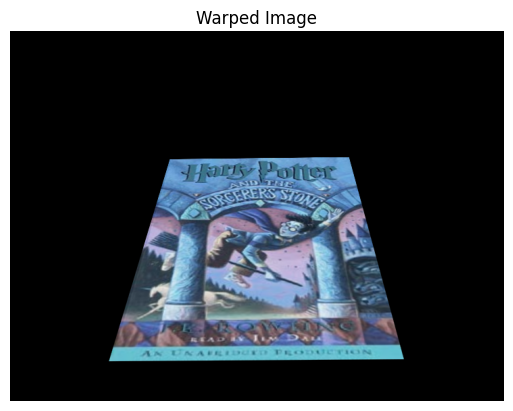

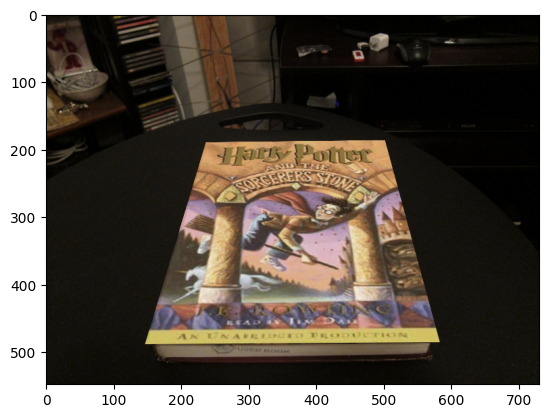

In [65]:
# defaults are:
# ratio = 0.7
# sigma = 0.15
# max_iters = 600
# inlier_tol = 1.0


# (no need to change this but can if you want to experiment)
ratio = 0.7
sigma = 0.15
max_iters = 600
inlier_tol = 1

warpImage(ratio, sigma, max_iters, inlier_tol)

### Q2.2.5 (10 points):

Conduct ablation study with various max_iters and inlier_tol values. Plot the result images and explain the effect of these two parameters respectively.

ablation test 
       Changes  max_iters  inlier_tol
0     Default        600           1
1   max_iters          3           1
2   max_iters          1           1
3  inlier_tol        600           5
4  inlier_tol        600          10


<ipython-input-43-93856fa3ecc0>:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 if img[int(center[0]+row1)][int(center[1]+col1)] < img[int(center[0]+row2)][int(center[1]+col2)] else 0


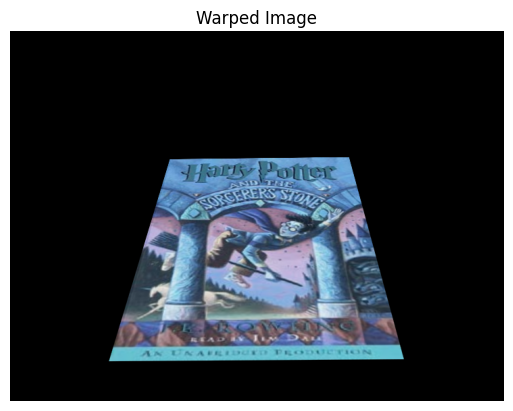

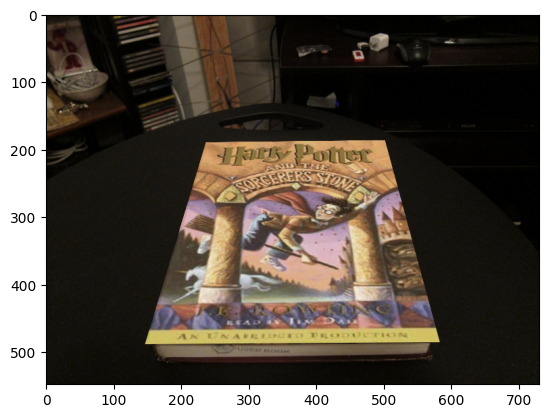

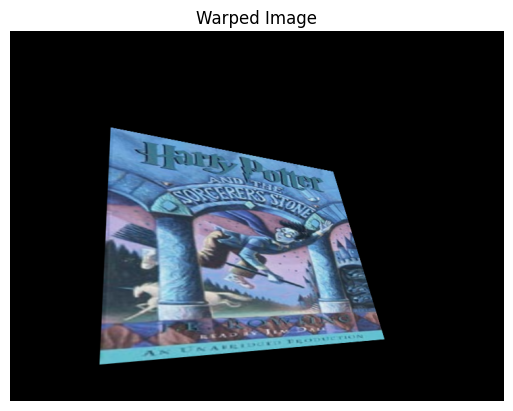

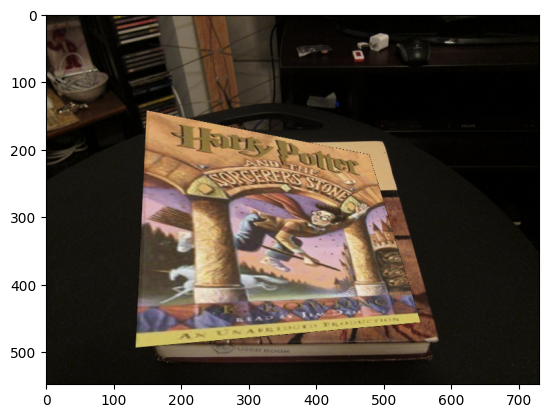

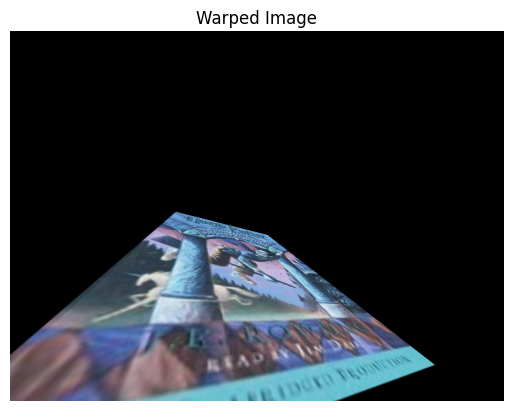

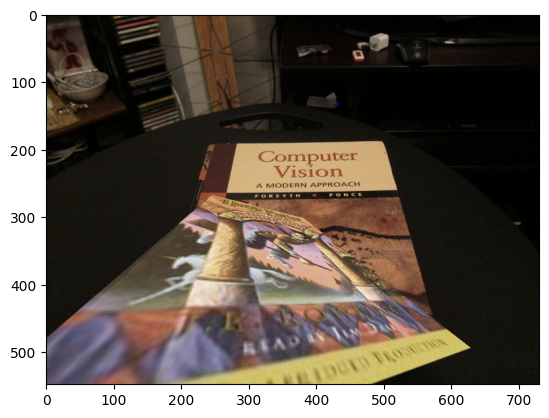

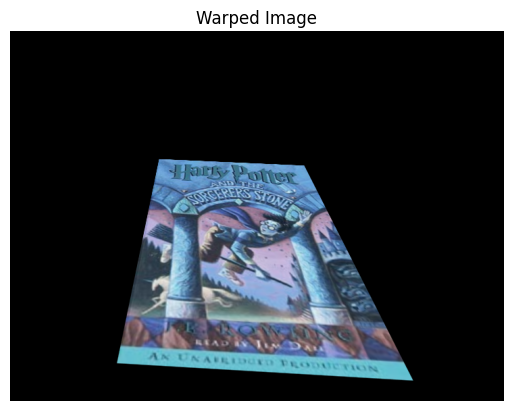

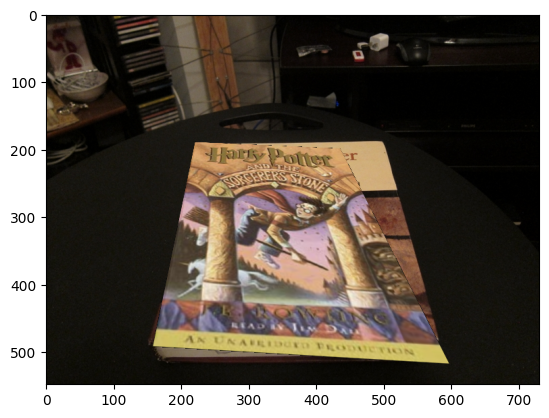

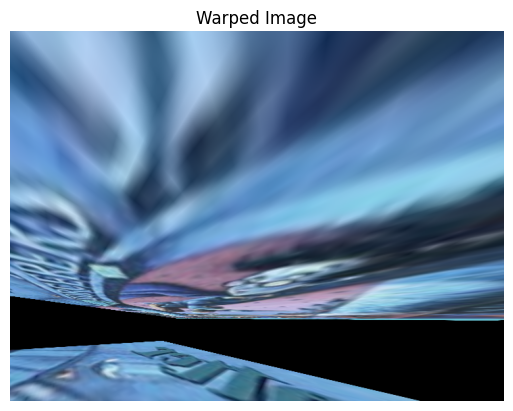

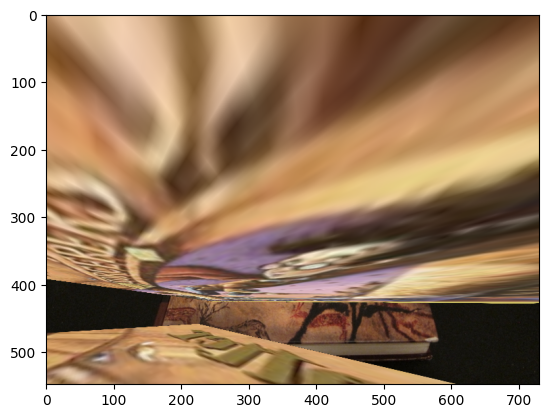

In [60]:
import pandas as pd
# defaults are:
# ratio = 0.7
# sigma = 0.15
# max_iters = 600
# inlier_tol = 1.0


# (no need to change this but can if you want to experiment)
ratio = 0.7
sigma = 0.15

data_hp = {
    'Changes': ['Default', 'max_iters', 'max_iters',
                'inlier_tol', 'inlier_tol'],
    'max_iters': [600, 3, 1, 600, 600],
    'inlier_tol': [1, 1, 1, 5, 10]
       }

df = pd.DataFrame(data_hp)

print("ablation test", '\n',df)


parameters = [(600, 1), (3, 1), (1, 1), (600, 100), (2, 400)]
for max_iters, inlier_tol in parameters:
    warpImage(ratio, sigma, max_iters, inlier_tol)
    print('\n')

# ==== end of code ====

---

`Explain the effect of max_iters and inlier_tol:`

`max_iters`

max iters affects the thoroughness of the search for a robust model, balancing accuracy against computation time.

Initially, I set the max_iters to relatively large values such as 500 and 400, but I found that the results did not change significantly. This might be because the number of matches was quite small, allowing good results to be achieved with fewer iterations. Therefore, I set the max_iters to much smaller values to make the effects more noticeable. We can observe that as max_iters decreases, the results increasingly deviate from the expected values.

`inlier_tol`

 Increasing inlier tol allows more points to be considered inliers, which can be beneficial in noisy environments but may also permit outliers to influence the homography, reducing its accuracy. However, decreasing inlier tol enhances precision but risks excluding valid correspondences. When inlier_tol is set to 400, we can clearly see that the image has completely lost its accuracy.



---

# Q3 Create a Simple Panorama

## Q3.1 Create a panorama (10 points):

#### Implement the function createPanorama

In [62]:
def createPanorama(left_im, right_im, ratio, sigma, max_iters, inlier_tol):
    """
    Create a panorama augmented reality application by computing a homography
    and stitching together a left and right image.

    Input
    -----
    left_im: left image
    right_im: right image
    ratio: ratio for BRIEF feature descriptor
    sigma: threshold for corner detection using FAST feature detector
    max_iters: the number of iterations to run RANSAC for
    inlier_tol: the tolerance value for considering a point to be an inlier

    Returns
    -------
    panorama_im: Stitched together panorama

    """
    # match features between images

    matches_pano, locs1_pano, locs2_pano = matchPics(right_im, left_im,
                                                     ratio, sigma)
    locs1_pano[:, [0, 1]] = locs1_pano[:, [1, 0]]
    locs2_pano[:, [0, 1]] = locs2_pano[:, [1, 0]]

    # ensure locs1 and locs2 have same amount of points which are matched
    matched_locs1_pano = locs1_pano[matches_pano[:, 0]]
    matched_locs2_pano = locs2_pano[matches_pano[:, 1]]

    print('matched_locs1_pano.shape[0] = ', matched_locs1_pano.shape[0])

    if matched_locs1_pano.shape[0] < 4:
        raise ValueError("Not enough matches between left_im and right_im.")

    # Get homography by RANSAC using computeH_ransac

    H2to1_pano, inliers_pano = computeH_ransac(matched_locs1_pano,
                                               matched_locs2_pano,
                                               max_iters,
                                               inlier_tol)
    if H2to1_pano is None:
        raise ValueError("H2to1_pan doesn't exist")

    # Stich together the two images

    composite_img_pano = compositeH(H2to1_pano, left_im, right_im)
    # ==== end of code ====
    plt.imshow(composite_img_pano)
    # plt.axis('off')
    plt.show()

    panorama_im = composite_img_pano

    return panorama_im.astype(np.uint8)

#### Visualize Panorama

Make sure to use **your own images** and **include them as well as the result** in the report.

<ipython-input-43-93856fa3ecc0>:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 if img[int(center[0]+row1)][int(center[1]+col1)] < img[int(center[0]+row2)][int(center[1]+col2)] else 0


matched_locs1_pano.shape[0] =  37


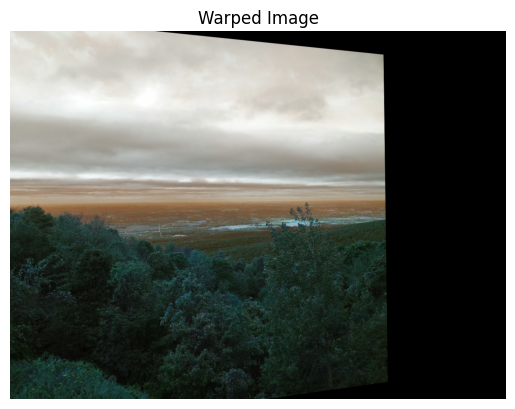

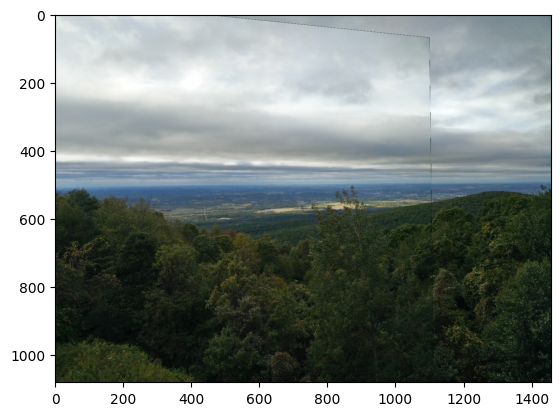

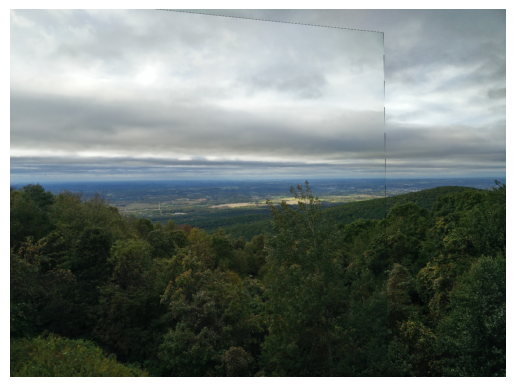

In [63]:
left_im_path = os.path.join(DATA_DIR, 'pano_left.jpg')
left_im = skimage.io.imread(left_im_path)
right_im_path = os.path.join(DATA_DIR, 'pano_right.jpg')
right_im = skimage.io.imread(right_im_path)

# Feel free to adjust as needed
ratio = 0.7
sigma = 0.15
max_iters = 10
inlier_tol = 1.0

panorama_im = createPanorama(left_im, right_im, ratio, sigma,
                             max_iters, inlier_tol)

plt.imshow(panorama_im)
plt.axis('off')
plt.show()